In [1]:
!pip install librosa

In [2]:
!wget "https://github.com/jeffprosise/Rainforest-Audio/archive/refs/heads/main.zip" -O temp.zip
!unzip -qq temp.zip && mv Rainforest-Audio-main Sounds && rm temp.zip

--2024-03-17 17:08:50--  https://github.com/jeffprosise/Rainforest-Audio/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/jeffprosise/Rainforest-Audio/zip/refs/heads/main [following]
--2024-03-17 17:08:50--  https://codeload.github.com/jeffprosise/Rainforest-Audio/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘temp.zip’

temp.zip                [          <=>       ] 666.17M  16.2MB/s    in 44s     

2024-03-17 17:09:35 (15.1 MB/s) - ‘temp.zip’ saved [698534121]



In [3]:
import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
%matplotlib inline

def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [4]:
create_pngs_from_wavs('Sounds/background', 'Spectrograms/background')
create_pngs_from_wavs('Sounds/chainsaw', 'Spectrograms/chainsaw')
create_pngs_from_wavs('Sounds/engine', 'Spectrograms/engine')
create_pngs_from_wavs('Sounds/storm', 'Spectrograms/storm')

In [5]:
from tensorflow.keras.preprocessing import image

def load_images_from_path(path, label):
    images, labels = [], []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file),
                                                        target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x, y = [], []

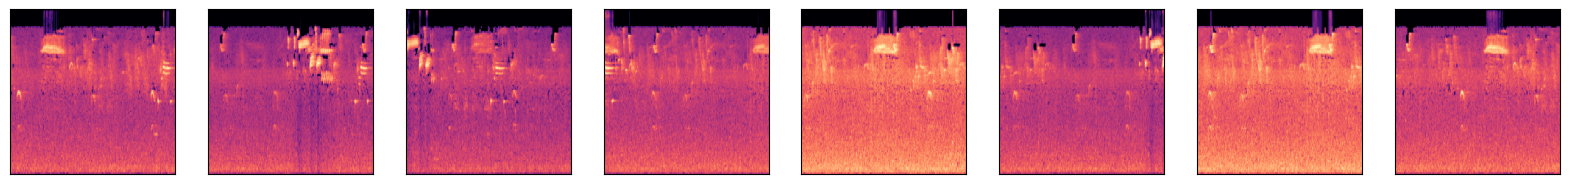

In [6]:
images, labels = load_images_from_path('Spectrograms/background', 0)
show_images(images)

x += images
y += labels

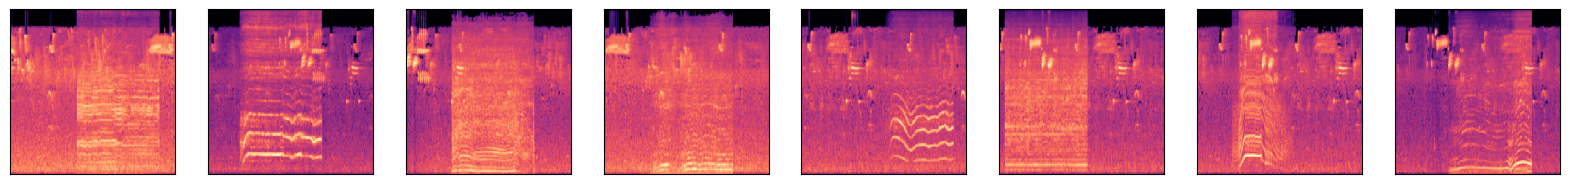

In [7]:
images, labels = load_images_from_path('Spectrograms/chainsaw', 1)
show_images(images)

x += images
y += labels

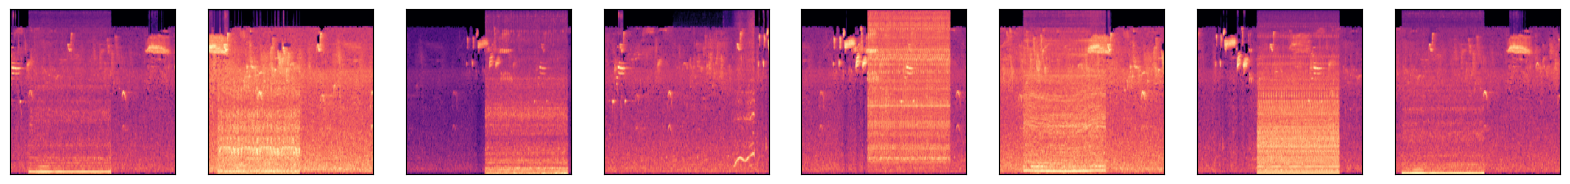

In [8]:
images, labels = load_images_from_path('Spectrograms/engine', 2)
show_images(images)

x += images
y += labels

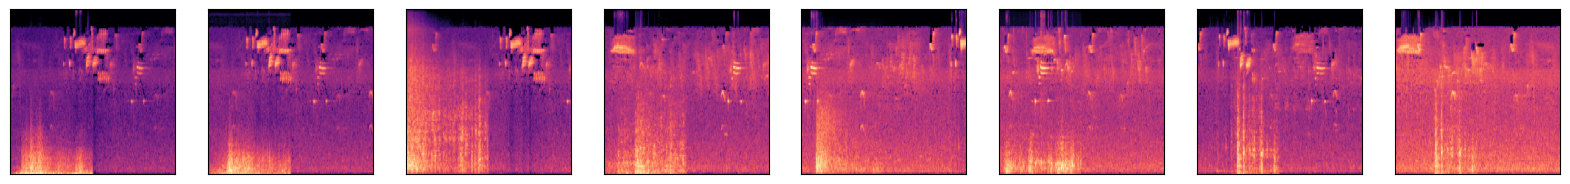

In [9]:
images, labels = load_images_from_path('Spectrograms/storm', 3)
show_images(images)

x += images
y += labels

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2,
                                                    random_state=0)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))

x_train_norm = preprocess_input(np.array(x_train))
x_test_norm = preprocess_input(np.array(x_test))

train_features = base_model.predict(x_train_norm)
test_features = base_model.predict(x_test_norm)

3/3 [==============================] - 1s 48ms/step


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [13]:
hist = model.fit(train_features, y_train, validation_data=(test_features, y_test),
                 batch_size=10, epochs=10)

Epoch 1/10
32/32 [==============================] - 2s 12ms/step - loss: 21.0850 - accuracy: 0.7000 - val_loss: 5.1027 - val_accuracy: 0.8875
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 1.6543 - accuracy: 0.9312 - val_loss: 3.2432 - val_accuracy: 0.9250
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 1.0828 - accuracy: 0.9500 - val_loss: 4.6688 - val_accuracy: 0.8875
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 1.1063 - accuracy: 0.9563 - val_loss: 3.2833 - val_accuracy: 0.9250
Epoch 5/10
32/32 [==============================] - 0s 6ms/step - loss: 2.3914 - accuracy: 0.9344 - val_loss: 12.1902 - val_accuracy: 0.8125
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 1.7064 - accuracy: 0.9469 - val_loss: 3.6911 - val_accuracy: 0.9000
Epoch 7/10
32/32 [==============================] - 0s 6ms/step - loss: 0.2342 - accuracy: 0.9812 - val_loss: 6.7949 - val_accuracy: 0.9000
Epoch 8/10
32/32 

[]

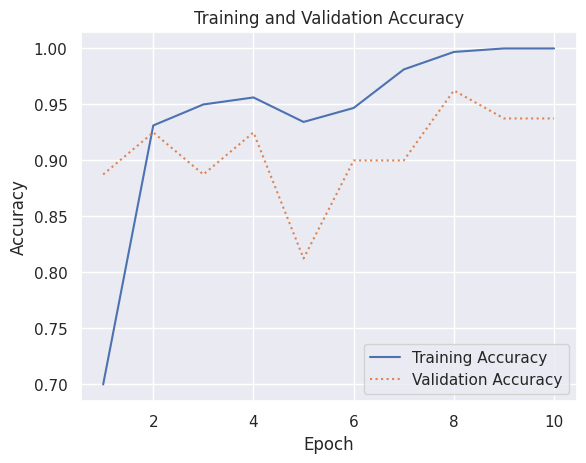

In [14]:
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

3/3 [==============================] - 0s 4ms/step


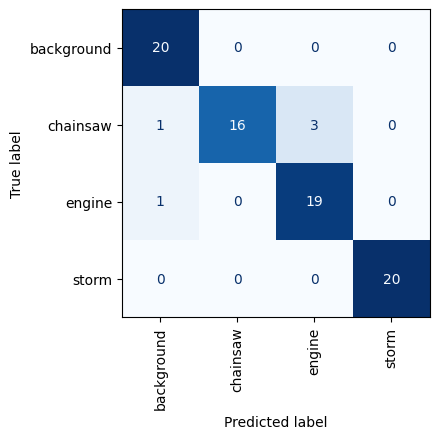

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd

sns.reset_orig()
fig, ax = plt.subplots(figsize=(4, 4))
y_pred = model.predict(test_features)
class_labels = ['background', 'chainsaw', 'engine', 'storm']

cmd.from_predictions(y_test, y_pred.argmax(axis=1),
                     display_labels=class_labels, colorbar=False,
                     cmap='Blues', xticks_rotation='vertical', ax=ax)

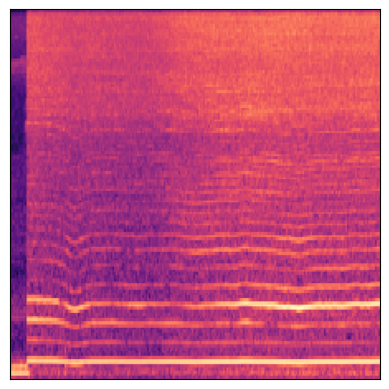

In [16]:
create_spectrogram('Sounds/samples/sample1.wav', 'Spectrograms/sample1.png')

x = image.load_img('Spectrograms/sample1.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [17]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = base_model.predict(x)
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

1/1 [==============================] - 0s 64ms/step
background: 0.0
chainsaw: 1.0
engine: 1.0171334852164589e-27
storm: 0.0


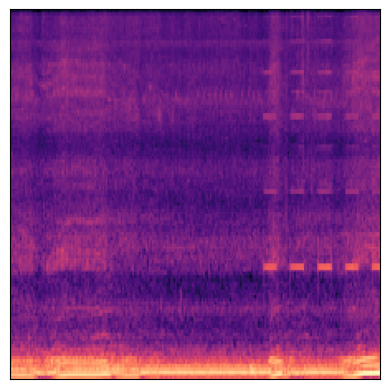

In [18]:
create_spectrogram('Sounds/samples/sample2.wav', 'Spectrograms/sample2.png')

x = image.load_img('Spectrograms/sample2.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [19]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = base_model.predict(x)
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

1/1 [==============================] - 0s 19ms/step
background: 0.0
chainsaw: 1.1972244659231914e-34
engine: 1.0
storm: 0.0
